In [1]:
import nltk
import numpy as np
import pandas as pd

#Language Processing
from nltk.tokenize import TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import emoji
from emoji import emojize
import string
import re

#Vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#SKLrean models
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

# set plot style
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#Wordcloud
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

In [3]:
new_df=df_train

In [4]:
sentiment_counts = df_train.sentiment.value_counts()
number_of_tweets = df_train.tweetid.count()
print(sentiment_counts)

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


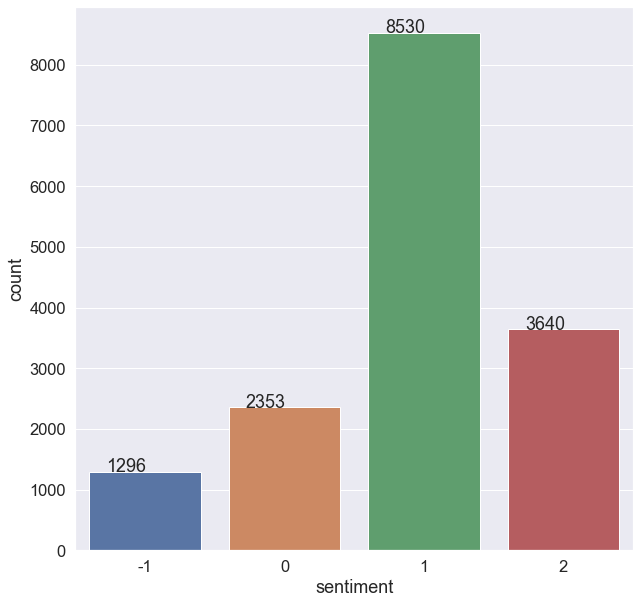

In [5]:
sns.set(font_scale=1.5)
fig, ax1 = plt.subplots(figsize=(10,10))
graph = sns.countplot(ax=ax1,x='sentiment', data=df_train)
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/3., height + 0.1,height ,ha="center")

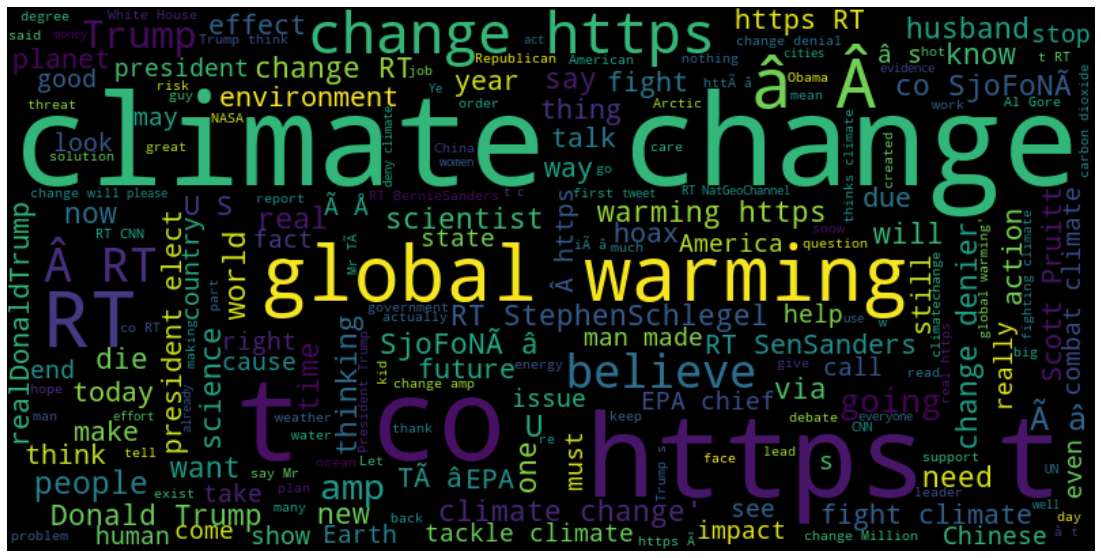

In [6]:
#Frequent words before cleaning the train set
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_train=" ".join([tweet for tweet in df_train['message']])
wordcloud = WordCloud(background_color='black',width=800, height=400,random_state=26,max_font_size=100).generate(words_train)
# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# EDA

In [7]:
df_copy = df_train.copy()
# Labeling the target
df_copy ['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in df_copy['sentiment']]

In [8]:
df_copy.head()

sentiment                                            message  tweetid
0  Positive  PolySciMajor EPA chief doesn't think carbon di...   625221
1  Positive  It's not like we lack evidence of anthropogeni...   126103
2      News  RT @RawStory: Researchers say we have three ye...   698562
3  Positive  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4  Positive  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

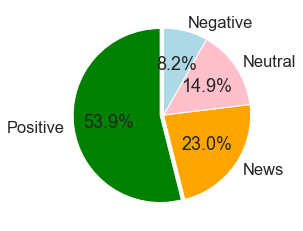

In [9]:
# checking the numerical distribution
values = df_copy['sentiment'].value_counts()/df_copy.shape[0]
labels = (df_copy['sentiment'].value_counts()/df_copy.shape[0]).index
colors = ['green', 'orange', 'pink', 'lightblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

In [10]:
def feature_count(argu):
    sentiment_df = df_copy[df_copy['message'].str.contains(argu)]
    sentiment_df = (sentiment_df.groupby('sentiment').count()/df.groupby('sentiment').count())*100
    sentiment_df['percentage'] = sentiment_df['message']
    sentiment_df = sentiment_df[['percentage']]
    
    return sentiment_df

grouped = df_copy.groupby(df_copy.sentiment)
deny_df = grouped.get_group('Negative')
pro_df = grouped.get_group('Positive')
media_df = grouped.get_group('News')
neutral_df = grouped.get_group('Neutral')

import itertools
import collections
# Create a list of lists containing lowercase words for each tweet
words_in_all_tweet = [tweet.split() for tweet in df_copy['message']]
deny_tweets_list = [deny_tweet.split() for deny_tweet in deny_df['message']]
pro_tweets_list = [pro_tweet.split() for pro_tweet in pro_df['message']]
media_tweets_list = [media_tweet.split() for media_tweet in media_df['message']]
neutral_tweets_list = [neutral_tweet.split() for neutral_tweet in neutral_df['message']]


# List of all words across tweets
clean_message_all_list= list(itertools.chain(*words_in_all_tweet))
clean_message_list_deny= list(itertools.chain(*deny_tweets_list))
clean_message_list_pro= list(itertools.chain(*pro_tweets_list))
clean_message_list_meida= list(itertools.chain(*media_tweets_list))
clean_message_list_neutral= list(itertools.chain(*neutral_tweets_list))

# Create counter
counts_clean_message_all = collections.Counter(clean_message_all_list)
counts_clean_message_deny = collections.Counter(clean_message_list_deny)
counts_clean_message_pro = collections.Counter(clean_message_list_pro)
counts_clean_message_media= collections.Counter(clean_message_list_meida)
counts_clean_message_neutral = collections.Counter(clean_message_list_neutral)

common_words_number = 15
counts_clean_message_all.most_common(common_words_number)
counts_clean_message_deny.most_common(common_words_number)
counts_clean_message_pro.most_common(common_words_number)
counts_clean_message_media.most_common(common_words_number)
counts_clean_message_neutral.most_common(common_words_number)

#Build a Dataframe of the words in the tweets as well as their count
tweet_word_counts_all = pd.DataFrame(counts_clean_message_all.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_deny = pd.DataFrame(counts_clean_message_deny.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_pro = pd.DataFrame(counts_clean_message_pro.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_media = pd.DataFrame(counts_clean_message_media.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_neutral = pd.DataFrame(counts_clean_message_neutral.most_common(common_words_number),
                             columns=['words', 'count'])

Text(0.5, 1.0, 'Common Words Found in neutral tweets')

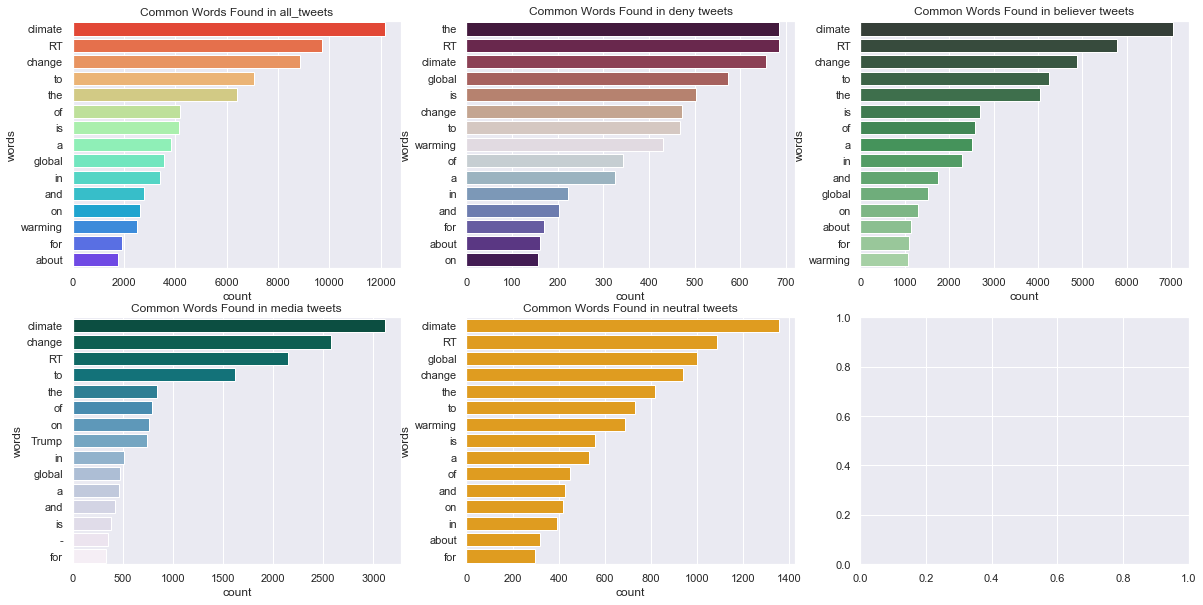

In [11]:
sns.set(font_scale=1)
fig, axes = plt.subplots(2,3, figsize=(20, 10), squeeze=False)

sns.barplot(y='words' ,x=tweet_word_counts_all['count'], data = tweet_word_counts_all.sort_values(by='count', ascending=False),ax=axes[0,0], palette = "rainbow_r", orient = 'h')
axes[0,0].set_title("Common Words Found in all_tweets")

sns.barplot(y='words' ,x=tweet_word_counts_deny['count'], data = tweet_word_counts_deny.sort_values(by='count', ascending=False),ax=axes[0,1], palette = "twilight_shifted_r", orient = 'h')
axes[0,1].set_title("Common Words Found in deny tweets")

sns.barplot(y='words' ,x=tweet_word_counts_pro['count'], data = tweet_word_counts_pro.sort_values(by='count', ascending=False),ax=axes[0,2], palette = "Greens_d", orient = 'h')
axes[0,2].set_title("Common Words Found in believer tweets")

sns.barplot(y='words' ,x=tweet_word_counts_media['count'], data = tweet_word_counts_media.sort_values(by='count', ascending=False),ax=axes[1,0], palette = "PuBuGn_r", orient = 'h')
axes[1,0].set_title("Common Words Found in media tweets")

sns.barplot(y='words' ,x=tweet_word_counts_neutral['count'], data = tweet_word_counts_neutral.sort_values(by='count', ascending=False),ax=axes[1,1], color = 'orange', orient = 'h')
axes[1,1].set_title("Common Words Found in neutral tweets")

# **Data Cleaning process**

In [12]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

# Cleaning links
#df_train["clean_tweet"] = df_train['message'].str.replace(r'https://\S+', "")
#df_test["clean_tweet"] = df_test['message'].str.replace(r'https://\S+', "")

In [16]:
def remove_pattern(input_text, patterns):
    helper = re.findall(patterns, input_text)
    for i in helper:
        input_text = re.sub(i, '', input_text)
    return input_text

# Remove Twitter handles from the train and test data 
df_train['clean_tweet'] = np.vectorize(remove_pattern)(df_train['message'], "@[\w]*")
df_test['clean_tweet'] = np.vectorize(remove_pattern)(df_test['message'], "@[\w]*")

In [17]:
pd.set_option('display.max_colwidth', -1)
df_train.head()

C:\Users\Mahlako Katlego\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


sentiment  \
0  1           
1  1           
2  2           
3  1           
4  1           

                                                                                                                                        message  \
0  PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable   
1  It's not like we lack evidence of anthropogenic global warming                                                                                 
2  RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…   
3  #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD                                            
4  RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight                     

   tweetid  \
0  625221    
1  126103    
2  698562    
3  573736    
4  466954    

                                                                                                                           clean_tweet  
0  PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via   
1  It's not like we lack evidence of anthropogenic global warming                                                                       
2  RT : Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…  
3  #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD                                  
4  RT : It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight

In [18]:
# Remove punctuations, numbers, and special characters
df_train['clean_tweet'] = df_train['message'].str.replace("[^a-zA-Z#]", " ")
df_test['clean_tweet'] = df_test['message'].str.replace("[^a-zA-Z#]", " ")

In [19]:
# Remove all words below 3 characters
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


In [20]:
pd.set_option('display.max_colwidth', -1)
df_train.head()

C:\Users\Mahlako Katlego\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


sentiment  \
0  1           
1  1           
2  2           
3  1           
4  1           

                                                                                                                                        message  \
0  PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable   
1  It's not like we lack evidence of anthropogenic global warming                                                                                 
2  RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…   
3  #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD                                            
4  RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight                     

   tweetid  \
0  625221    
1  126103    
2  698562    
3  573736    
4  466954    

                                                                                                   clean_tweet  
0  PolySciMajor chief doesn think carbon dioxide main cause global warming wait what https yeLvcEFXkC mashable  
1  like lack evidence anthropogenic global warming                                                              
2  RawStory Researchers have three years climate change before late https KdUr https ANPT                       
3  #TodayinMaker# WIRED pivotal year climate change https wOTxTLcD                                              
4  SoyNovioDeTodas racist sexist climate change denying bigot leading polls #ElectionNight

In [21]:
#Further cleaning
def cleandata(message):

    #translate emojis if we have
    message = emoji.demojize(message, delimiters=("", "")) 

    #lowercase
    message = message.lower() 
    
    #lemmatisation and tokenization
    lemmatizer = WordNetLemmatizer()
    message = [lemmatizer.lemmatize(token) for token in message.split(' ')]
    message = [lemmatizer.lemmatize(token, 'v') for token in message]
    message = ' '.join(message)

    return message

In [22]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df_train['clean_tweet'] = df_train.clean_tweet.apply(cleandata)
df_test['clean_tweet'] = df_test.clean_tweet.apply(cleandata)
df_train.head()

C:\Users\Mahlako Katlego\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


sentiment  \
0  1           
1  1           
2  2           
3  1           
4  1           

                                                                                                                                        message  \
0  PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable   
1  It's not like we lack evidence of anthropogenic global warming                                                                                 
2  RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…   
3  #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD                                            
4  RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight                     

   tweetid  \
0  625221    
1  126103    
2  698562    
3  573736    
4  466954    

                                                                                               clean_tweet  
0  polyscimajor chief doesn think carbon dioxide main cause global warm wait what http yelvcefxkc mashable  
1  like lack evidence anthropogenic global warm                                                             
2  rawstory researcher have three year climate change before late http kdur http anpt                       
3  #todayinmaker# wire pivotal year climate change http wotxtlcd                                            
4  soynoviodetodas racist sexist climate change deny bigot lead poll #electionnight

In [23]:
df_test.head()

message  \
0  Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq                     
1  Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj          
2  The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..   
3  @Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax   
4  RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican                                                              

   tweetid  \
0  169760    
1  35326     
2  224985    
3  476263    
4  872928    

                                                                                                         clean_tweet  
0  europe will look china make sure that alone fight climate change http rcgwdq                                       
1  combine this with poll staffer climate change woman right have fascist state http ifrm eexpj                       
2  scary unimpeachable evidence that climate change already here http yaedqcv #itstimetochange #climatechange zeroco  
3  karoli morgfair osborneink dailykos putin jill trump doesn believe climate change think hoax                       
4  fakewillmoore female orgasm cause global warm sarcastic republican

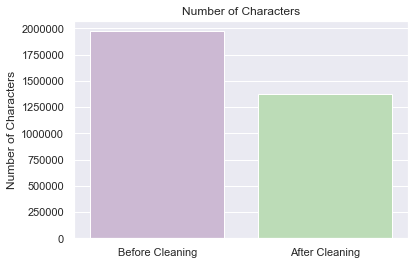

In [24]:
# Combining all the messages
text_before_cleaning = " ".join(tweet for tweet in df_train['message'])
text_after_cleaning = " ".join(tweet for tweet in df_train['clean_tweet'])

# Numbers of characters before and after cleaning for both 
sns.barplot(x=['Before Cleaning', 'After Cleaning'], y=[len(text_before_cleaning), len(text_after_cleaning)], palette='PRGn')
# sns.countplot(x=[] ,data = working_df, palette='PRGn')
plt.ylabel('Number of Characters')
# plt.xlabel('Sentiment')
plt.title('Number of Characters')
plt.show()

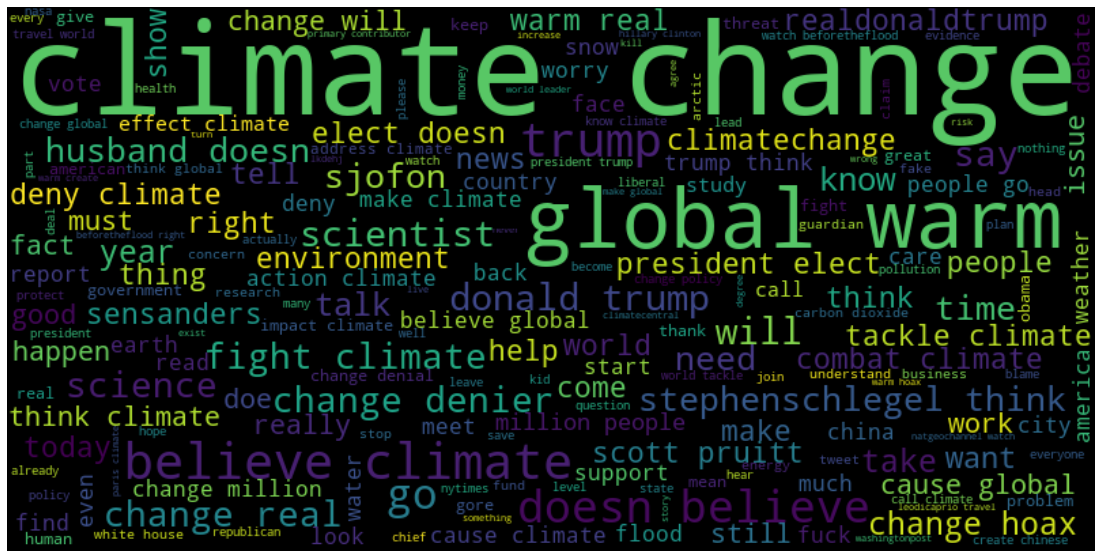

In [25]:
#Most frequent words in the train set
from wordcloud import WordCloud
words_train=" ".join([tweet for tweet in df_train['clean_tweet']])
wordcloud = WordCloud(background_color='black',width=800, height=400,random_state=42,max_font_size=100).generate(words_train)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


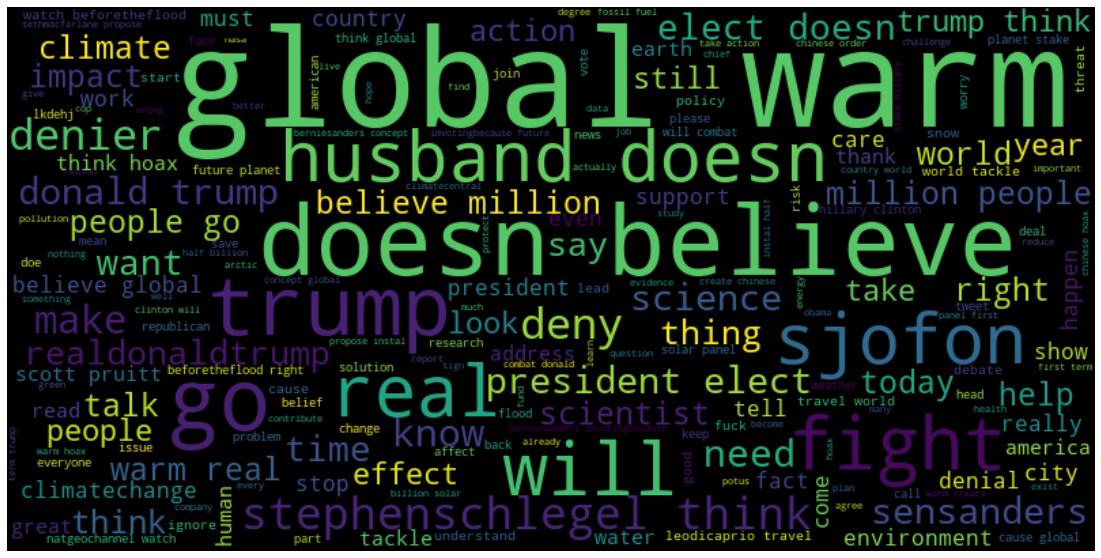

In [26]:
#Most positive frequent words 
from wordcloud import WordCloud
positive=re.sub("climate change",''," ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==1]]))
wordcloud = WordCloud(background_color='black',width=800, height=400,random_state=42,max_font_size=100).generate(positive)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

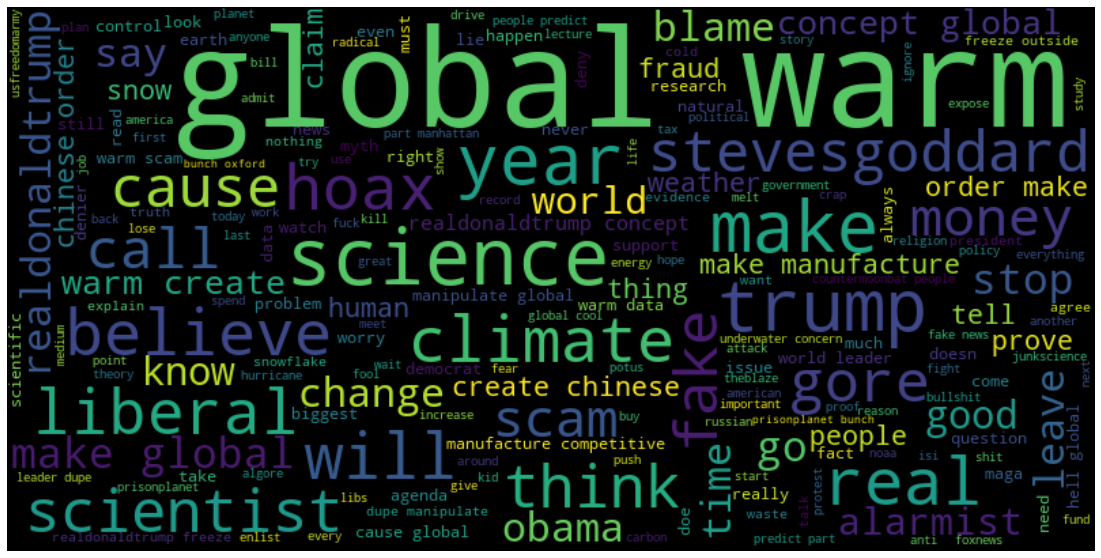

In [27]:
#Most negative frequent words 
negative=re.sub("climate change",''," ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==-1]]))
wordcloud = WordCloud(background_color='black',width=800, height=400,random_state=42,max_font_size=100).generate(negative)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

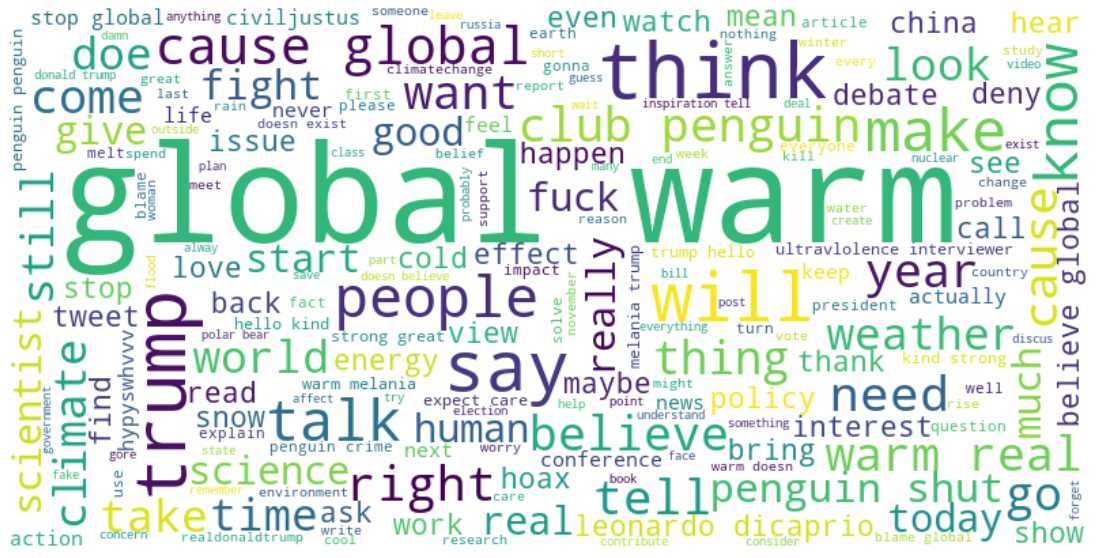

In [28]:
#Most neutral frequent words 
neutral=re.sub("climate change",''," ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==0]]))
wordcloud = WordCloud(background_color='white',width=800, height=400,random_state=26,max_font_size=100).generate(neutral)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

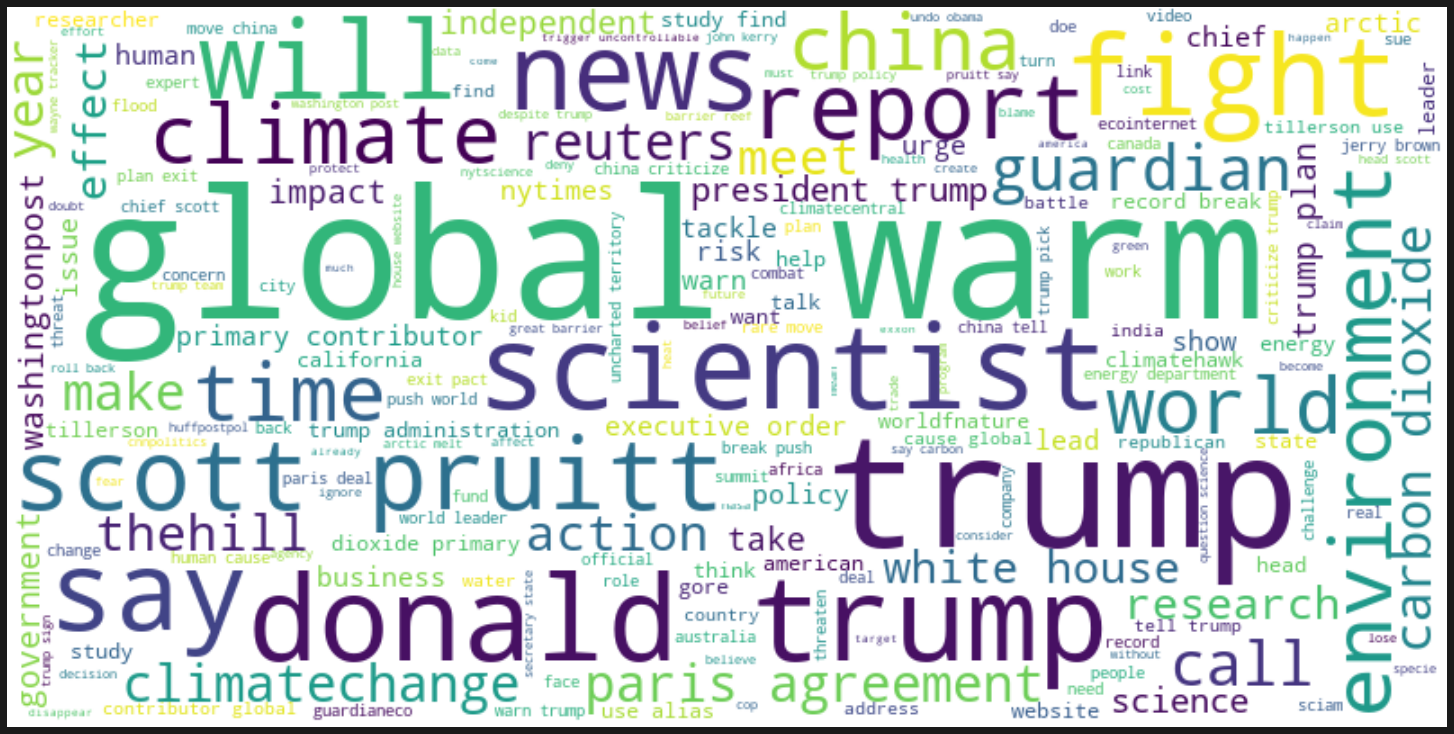

In [29]:
#Most news frequent words 

new= re.sub("climate change", ''," ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==2]]))
wordcloud = WordCloud(background_color='white',width=800, height=400,random_state=26,max_font_size=100).generate(new)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [30]:
#Apply data cleandata function to data
#df_train['clean_tweet'] = df_train['message'].map(cleandata)
#df_test['clean_tweet'] = df_test['message'].map(cleandata)

In [31]:
# importing the module and creating a resampling variable
#from sklearn.utils import resample
#class_size = int(len(new_df[new_df['sentiment']==1])/2)

In [32]:
#df_majority_1 = new_df[new_df['sentiment']==1] 
#df_minority_0 = new_df[new_df['sentiment']==0] 
#df_minority_neg1 = new_df[new_df['sentiment']==-1] 
#df_minority_2 = new_df[new_df['sentiment']==2] 

In [33]:
#df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=class_size, random_state=47)      
#df_minority_neg1_upsampled = resample(df_minority_neg1, replace=True, n_samples=class_size, random_state=47)   
#df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=class_size, random_state=47)   
#df_majority_1_downsampled= resample(df_majority_1,replace=False,n_samples=class_size, random_state=27)

###combining all upscaled classes into a single df, df_comb
#df_combination = pd.concat([df_majority_1_downsampled, df_minority_0_upsampled, df_minority_neg1_upsampled, df_minority_2_upsampled])

In [34]:
#df_combination.sentiment.value_counts()

In [35]:
#new_df.head()

In [36]:
# Checking if data has been well-balanced
#sns.countplot(x = df_combination['sentiment'],  palette='PRGn')
#plt.show()

In [37]:
# Defining the features as well as the label
#X1 = df_combination['message']
#X_res = X1.apply(cleandata)
#y_res = df_combination['sentiment']

#X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

In [38]:
df_copy1 = df_train.copy()
# Labeling the target
df_copy1['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in df_copy1['sentiment']]

In [39]:
df_copy1.head()

sentiment  \
0  Positive   
1  Positive   
2  News       
3  Positive   
4  Positive   

                                                                                                                                        message  \
0  PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable   
1  It's not like we lack evidence of anthropogenic global warming                                                                                 
2  RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…   
3  #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD                                            
4  RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight                     

   tweetid  \
0  625221    
1  126103    
2  698562    
3  573736    
4  466954    

                                                                                               clean_tweet  
0  polyscimajor chief doesn think carbon dioxide main cause global warm wait what http yelvcefxkc mashable  
1  like lack evidence anthropogenic global warm                                                             
2  rawstory researcher have three year climate change before late http kdur http anpt                       
3  #todayinmaker# wire pivotal year climate change http wotxtlcd                                            
4  soynoviodetodas racist sexist climate change deny bigot lead poll #electionnight

In [40]:
def feature_count(argu2):
    sentiment_df1 = df_copy1[df_copy1['clean_tweet'].str.contains(argu2)]
    sentiment_df1 = (sentiment_df1.groupby('sentiment').count()/df.groupby('sentiment').count())*100
    sentiment_df1['percentage'] = sentiment_df1['clean_tweet']
    sentiment_df1 = sentiment_df1[['percentage']]
    
    return sentiment_df1
grouped1 = df_copy1.groupby(df_copy1.sentiment)
deny_df1 =grouped1.get_group('Negative')
pro_df1 = grouped1.get_group('Positive')
media_df1 = grouped1.get_group('News')
neutral_df1 = grouped1.get_group('Neutral')

import itertools
import collections
# Create a list of lists containing lowercase words for each tweet
words_in_all_tweet1 = [tweet.split() for tweet in df_copy1['clean_tweet']]
deny_tweets_list1 = [deny_tweet.split() for deny_tweet in deny_df1['clean_tweet']]
pro_tweets_list1 = [pro_tweet.split() for pro_tweet in pro_df1['clean_tweet']]
media_tweets_list1 = [media_tweet.split() for media_tweet in media_df1['clean_tweet']]
neutral_tweets_list1 = [neutral_tweet.split() for neutral_tweet in neutral_df1['clean_tweet']]


# List of all words across tweets
clean_message_all_list1= list(itertools.chain(*words_in_all_tweet1))
clean_message_list_deny1= list(itertools.chain(*deny_tweets_list1))
clean_message_list_pro1= list(itertools.chain(*pro_tweets_list1))
clean_message_list_meida1= list(itertools.chain(*media_tweets_list1))
clean_message_list_neutral1= list(itertools.chain(*neutral_tweets_list1))

# Create counter
counts_clean_message_all1 = collections.Counter(clean_message_all_list1)
counts_clean_message_deny1 = collections.Counter(clean_message_list_deny1)
counts_clean_message_pro1 = collections.Counter(clean_message_list_pro1)
counts_clean_message_media1= collections.Counter(clean_message_list_meida1)
counts_clean_message_neutral1 = collections.Counter(clean_message_list_neutral1)

common_words_number = 15
counts_clean_message_all1.most_common(common_words_number)
counts_clean_message_deny1.most_common(common_words_number)
counts_clean_message_pro1.most_common(common_words_number)
counts_clean_message_media1.most_common(common_words_number)
counts_clean_message_neutral1.most_common(common_words_number)

#Build a Dataframe of the words in the tweets as well as their count
tweet_word_counts_all1 = pd.DataFrame(counts_clean_message_all1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_deny1 = pd.DataFrame(counts_clean_message_deny1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_pro1 = pd.DataFrame(counts_clean_message_pro1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_media1 = pd.DataFrame(counts_clean_message_media1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_neutral1 = pd.DataFrame(counts_clean_message_neutral1.most_common(common_words_number),
                             columns=['words', 'count'])

Text(0.5, 1.0, 'Common Words Found in neutral tweets after data cleaning')

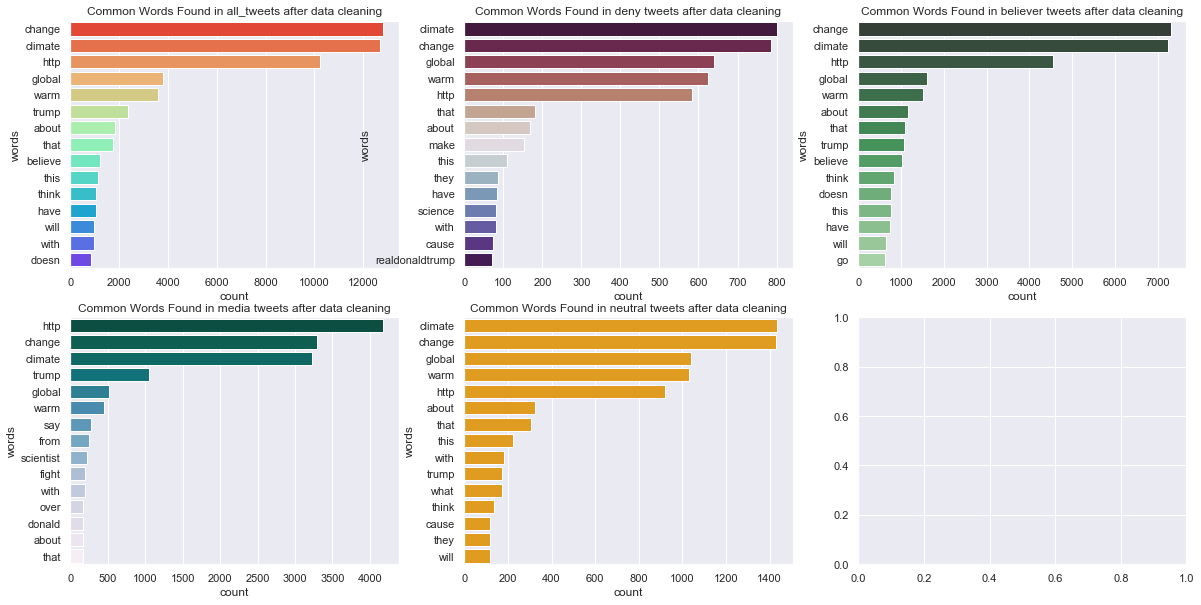

In [41]:
sns.set(font_scale=1)
fig, axes = plt.subplots(2,3, figsize=(20, 10), squeeze=False)

sns.barplot(y='words' ,x=tweet_word_counts_all1['count'], data = tweet_word_counts_all1.sort_values(by='count', ascending=False),ax=axes[0,0], palette = "rainbow_r", orient = 'h')
axes[0,0].set_title("Common Words Found in all_tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_deny1['count'], data = tweet_word_counts_deny1.sort_values(by='count', ascending=False),ax=axes[0,1], palette = "twilight_shifted_r", orient = 'h')
axes[0,1].set_title("Common Words Found in deny tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_pro1['count'], data = tweet_word_counts_pro1.sort_values(by='count', ascending=False),ax=axes[0,2], palette = "Greens_d", orient = 'h')
axes[0,2].set_title("Common Words Found in believer tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_media1['count'], data = tweet_word_counts_media1.sort_values(by='count', ascending=False),ax=axes[1,0], palette = "PuBuGn_r", orient = 'h')
axes[1,0].set_title("Common Words Found in media tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_neutral1['count'], data = tweet_word_counts_neutral1.sort_values(by='count', ascending=False),ax=axes[1,1], color = 'orange', orient = 'h')
axes[1,1].set_title("Common Words Found in neutral tweets after data cleaning")

# **Split data**

In [42]:
X = df_train['clean_tweet']
y = df_train['sentiment']

X_real = df_test['message']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30,  shuffle = True, stratify=y)


# Modelling

In [43]:
# define base learner models
level0 = list()
level0.append(('mnb', MultinomialNB()))
level0.append(('mnb0.001', MultinomialNB(alpha = 0.001)))
level0.append(('lr', LogisticRegression(n_jobs=-1)))
level0.append(('lr2', LogisticRegression(C = 100, max_iter=5000, n_jobs=-1)))
level0.append(('svc', SVC(kernel='linear')))

In [44]:
#Model1(definening meta model and define stacking ensemble)
level1 = LinearSVC()
model = StackingClassifier(estimators=level0, final_estimator=level1)
pipe = Pipeline([ ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                 ('clf', model)
                ], verbose = 10)
pipe.fit(X_train, y_train)

#Predict and evaluate
y_pred_lsvc = pipe.predict(X_test)

print('model: Linear SVC Metrics')
print(metrics.classification_report(y_test, y_pred_lsvc))

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 7.1min
model: Linear SVC Metrics
              precision    recall  f1-score   support

          -1       0.70      0.46      0.56       259
           0       0.64      0.36      0.46       471
           1       0.77      0.85      0.81      1706
           2       0.72      0.82      0.77       728

    accuracy                           0.74      3164
   macro avg       0.71      0.62      0.65      3164
weighted avg       0.73      0.74      0.73      3164



In [45]:
print("F1 Score:",f1_score(y_test, y_pred_lsvc,average='weighted'))

F1 Score: 0.7266197777343786


In [46]:
X_real = df_test['message']

y_pred_lr_real = pipe.predict(X_real)

df_test['sentiment'] = y_pred_lr_real

In [47]:
df_test[['tweetid','sentiment']].to_csv('Team_8.csv', index=False)

In [48]:
df_test.head(50)

message  \
0   Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq                                
1   Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj                     
2   The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..              
3   @Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax              
4   RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican                                                                         
5   RT @nycjim: Trump muzzles employees of several gov’t agencies in effort to suppress info on #climate change &amp; the environment. https://t.co…         
6   @bmastenbrook yes wrote that in 3rd yr Comp Sci ethics part. Was told by climate change denying Lecturer that I was wrong &amp; marked down.             
7   RT @climatehawk1: Indonesian farmers weather #climate change w/ conservation agriculture | @IPSNews https://t.co/1NZUCCMlYr…                             
8   RT @guardian: British scientists face a ‘huge hit’ if the US cuts climate change research https://t.co/KlKQnYDXzh                                        
9   Aid For Agriculture | Sustainable agriculture and climate change adaptation for small-scale farmers https://t.co/q7IPCP59x9 via @aid4ag                  
10  There is no climate change, Globalists! https://t.co/s9x0yNkhhS                                                                                          
11  Biggest threat to our economy is climate change https://t.co/oLzX7yZ9NF                                                                                  
12  RT @100isNow: He's CEO of a company that lied about climate change. Now he'll be Secretary of State. Meet Rex Tillerson…                                 
13  RT @VICE: Venice could be swallowed by water within a century thanks to global warming: https://t.co/h9rvoxAoGA https://t.co/RPKeH8zyKo                  
14  RT @Total_CardsMove: 'It's so warm outside because of climate change.'\n\nHA don't be naive. We all know it's because the Cubs are in the WSÃ¢â‚¬Â¦      
15  Niggas ask me what my inspiration was I told em global warming you feel me I'm too cozy                                                                  
16  RT @SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. TÃ¢â‚¬Â¦               
17  RT @sccscot: We welcome recommendations published by MSPs today to improve Scotland's plan to tackle climate change #scotclimate…                        
18  RT @yajairaxlove: Mid-November &amp; it's hot as hell ... \n\nBut global warming is a hoax oh.                                                           
19  Record-breaking climate change pushes world into 'uncharted territory' - The Guardian https://t.co/VCPiGKih5U                                            
20  RT @AdamsFlaFan: #BigOilOwned House science chairman gets heat in Texas race for being a global warming skeptic https://t.co/uhFBfWJMwo                  
21  RT @thehill: Bill Nye slams CNN for having climate change skeptic on air https://t.co/5u8zGZh9hX https://t.co/DTCDdUGFOb                                 
22  Michael Moore calls Trump’s actions on climate change ‘Declaration of War’ https://t.co/zR3aAQekQz #Eco #Green                                           
23  RT @SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. TÃ¢â‚¬Â¦               
24  @LeoDiCaprio 's #BeforeTheFlood is such a masterpiece. Never knew so many things were associated with global warming.                                    
25  @injculbard @martinstiff pretty sur